In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tweepy
from tqdm.notebook import tqdm

In [2]:
twitter_credentials = []
with open('../../../../twitter_credentials.json', 'r') as f:
    twitter_credentials = json.load(f)        

# TwitterAPI Authentication
auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'],
                                   twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token_key'],
                              twitter_credentials['access_token_secret'])
API = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=60*5)

In [7]:
def get_ids(df):
    true_id = []
    for acc in tqdm(df):
        if acc != '':
            try:
                user = API.get_user(acc)
                true_id.append(user.id)
            except:
                true_id.append(0)
        else:
             true_id.append(0)
    return true_id

In [4]:
def remove_training_data(df, pol_id):
    for i, acc in enumerate(df['Twitter Handle']):
        if acc in pol_id:
            df = df.drop(i)
    return df

In [146]:
def print_results(df):
    fn_acc = df[df['Twitter Handle'] != 0].copy() 

    top1 = [False for i in range(len(fn_acc))]
    top5 = [False for i in range(len(fn_acc))]
    top10 = [False for i in range(len(fn_acc))]

    for i, acc in enumerate(fn_acc['Twitter Handle']):
        for j,res in enumerate(fn_acc[[f'Result {k+1}' for k in range(2)]].iloc[i].unique()):
            if acc == res:
                if j < 1:
                    top1[i] = True
                elif 0 < j < 6:
                    top5[i] = True
                else:
                    top10[j] = True

    found = [a or b or c for a,b,c in zip(top1,top5,top10)]

    fig, ax = plt.subplots()
    color_palette_list = ['#009BD0', '#00BDCC', '#ADD8E6']

    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor']= 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['font.size']=14

    x = [top1.count(True), top5.count(True), found.count(False)]
    labels = ['Top 1', 'Top 5' ,'Was not found']
    _=ax.pie(x, colors=color_palette_list,
         autopct='%1.0f%%', shadow=True, startangle=90, pctdistance=0.5,labeldistance=1.3, explode=(0.01,0.01,0.1))
    ax.legend(frameon=True, bbox_to_anchor=(1,0.75), labels=labels)

    target_names = ['Has an Account', 'Does not have a Account']
    fn_noacc = df[df['Twitter Handle'] == 0].copy() 
    correct = []
    for i, acc in enumerate(fn_noacc['Twitter Handle']):
        if acc == fn_noacc['Result 1'].iloc[i]:
            correct.append(True)
        else:
            correct.append(False) 
    correct.count(True), correct.count(False)
    fin_result = np.array([[found.count(True),correct.count(True)],
                      [found.count(False),correct.count(False)]])
    print(fin_result)

    pd.DataFrame(fin_result, 
             columns=['Uses Twitter', 'Does not use Twitter'], 
             index=['Correct', 'Incorrect']).T.plot(kind='barh')

# Training Set

In [155]:
clf_df = pd.read_csv("../../../../datasets/Greek Politicians/classification/parliament_members_training_set.csv",
                    usecols=['screen_name', 'parliament_member'])
clf_df = clf_df[clf_df['parliament_member'] != 0]['screen_name'].to_frame()
clf_df = clf_df.reset_index().drop('index', axis=1)
clf_df['screen_name'] = get_ids(clf_df['screen_name'])
clf_df.head()

  0%|          | 0/150 [00:00<?, ?it/s]

,screen_name
0,547869595
1,393292109
2,112445908
3,583853188
4,204069781


# Search: Fullnames

In [8]:
df = pd.read_csv('Twitter-Search-Fullnames-Parliament-Members.csv')
df = df.replace(np.nan, '')
df['Twitter Handle'] = get_ids(df['Twitter Handle'])

  0%|          | 0/300 [00:00<?, ?it/s]

[[ 84  57]
 [155   4]]


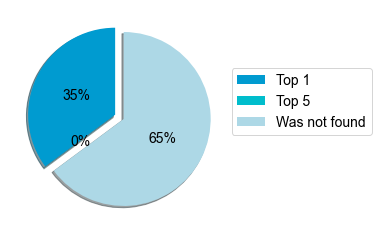

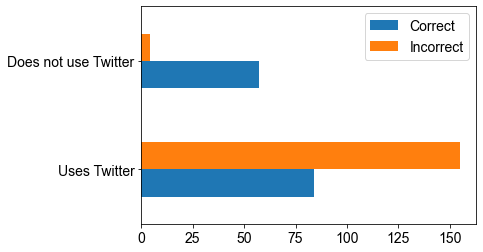

In [148]:
df = pd.read_csv('Twitter-Search-Fullnames-ClassifierND-Parliament-Members.csv')
df = df.replace(np.nan, '')
result = []
for i in df.index:
    temp = list(df[['Result 1', 'Result 2']].iloc[i])
    temp = [item for item in temp if item != 0]
    if not temp:
        temp += [0,0]
    elif len(temp) == 1:
        temp += [0]
    result.append(temp)
result = np.array(result)
df['Result 1'] = result[:,0]
df['Result 2'] = result[:,1]



df = remove_training_data(df, list(clf_df.screen_name))
df = df.reset_index().drop('index', axis=1)
print_results(df)

# Search: Surnames

## Without Classification

[[  0   0]
 [167   0]]


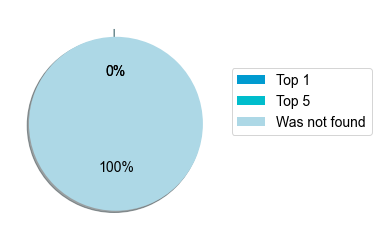

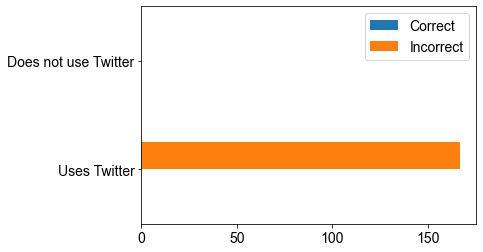

In [151]:
df = pd.read_csv('Twitter-Search-Surnames-Parliament-Members.csv')
df = df.replace(np.nan, '')
df = remove_training_data(df, list(clf_df.screen_name))
df = df.reset_index().drop('index', axis=1)
print_results(df)

[[114  52]
 [125   9]]


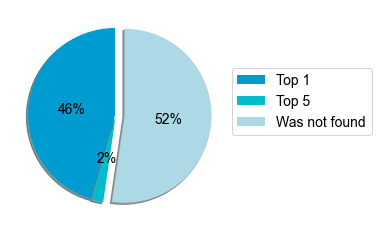

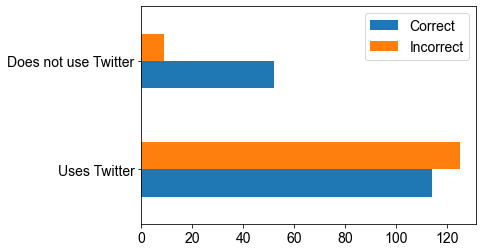

In [149]:
df = pd.read_csv('Twitter-Search-Surnames-ClassifierND-Parliament-Members.csv')
df = clean_zeros(df)
df = remove_training_data(df, list(clf_df.screen_name))
df = df.reset_index().drop('index', axis=1)
print_results(df)

# Search: SurnamesLatin

[[18 60]
 [73  1]]


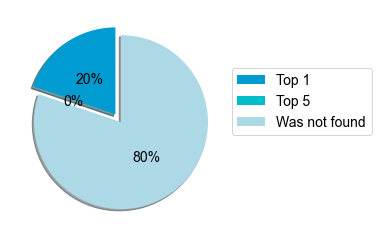

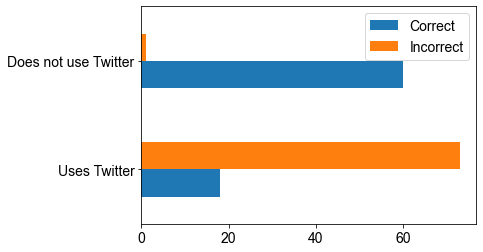

In [139]:
df = pd.read_csv('Twitter-Search-SurnamesLatin-ClassifierND-Parliament-Members.csv')
df = clean_zeros(df)
df = remove_training_data(df, list(clf_df.screen_name))
df = df.reset_index().drop('index', axis=1)
print_results(df)

In [140]:
len(df)

152